In [1]:
import os
import pickle


import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

In [2]:
pwd

'/Users/cock/kDrive/PhD/Projects/Labs/blind-mitigation/notebooks/1_ algos_investigation'

In [3]:
cd ../../src

/Users/cock/kDrive/PhD/Projects/Labs/blind-mitigation/src


In [4]:
from ml.models.flipped_bilstm import FlippedBiLSTMModel

/opt/anaconda3/envs/PhetGPU/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


# Read Data and results

In [5]:
vinitra_data_path = '../data/flipped_classrooms/features/roberta_vinitra_mirko_julien_features.pkl'
results_path = '../experiments/no_os/flipped/pass/flipped/cluster_demo_features/flipped_bilstm/pass/2022_08_31_0/results/nonnested_cval_mfcbilstm_lx.pkl'
config_path = '../experiments/no_os/flipped/pass/flipped/cluster_demo_features/flipped_bilstm/pass/2022_08_31_0/config.yaml'


with open(vinitra_data_path, 'rb') as fp:
    flipped = pickle.load(fp)
    
with open(results_path, 'rb') as fp:
    baseline = pickle.load(fp)
    
with open(config_path, 'rb') as fp:
    config_file = pickle.load(fp)

# Functions

In [6]:
# aesthetic

def choose_colours(n=1):
    palette = [
        '#E5F9F8', '#F92A82', '#FF9F1C', '#FFBF69', '#CBF3F0', '#2EC4B6'
    ]
    if n>6:
        replace = True
    else:
        replace=False
    return np.random.choice(palette, n, replace=replace)

palette = {
    'tp': '#FF9F1C',
    'fp': '#cbf3f0',
    'fn': '#F92A82'
}

In [7]:
# Compute Rates

def compute_tp(ypred, ytrue):
    assert len(ypred) == len(ytrue)
    pos_idx = [i for i in range(len(ytrue)) if ytrue[i] == 1]
    ps = len(pos_idx)
    tps = len([ypred[idx] for idx in pos_idx if ypred[idx] == 1])
    return tps / ps

def compute_fp(ypred, ytrue):
    assert len(ypred) == len(ytrue)
    neg_idx = [i for i in range(len(ytrue)) if ytrue[i] == 0]
    fps = len([ypred[idx] for idx in neg_idx if ypred[idx] == 1])
    tns = len(neg_idx) - fps
    return fps / (fps + tns)

def compute_fn(ypred, ytrue):
    assert len(ypred) == len(ytrue)
    pos_idx = [i for i in range(len(ytrue)) if ytrue[i] == 1]
    ps = len(pos_idx)
    tps = len([ypred[idx] for idx in pos_idx if ypred[idx] == 1])
    fns = ps - tps
    return fns / (fns + tps)
    
    

In [8]:
# Cluster functions
def compute_rates(ytrues, ypreds, associated_clusters, cluster):
    assert len(ytrues) == len(ypreds) and len(ypreds) == len(associated_clusters)
    cluster_idx = [i for i in range(len(associated_clusters)) if associated_clusters[i] == cluster]
    yt = [ytrues[idx] for idx in cluster_idx]
    yps = [ypreds[idx] for idx in cluster_idx]
    
    tp = compute_tp(yps, yt)
    fp = compute_fp(yps, yt)
    fn = compute_fn(yps, yt)
    
    return tp, fp, fn

def plot_rates(ytrues, ypreds, associated_clusters, dataset):
    unique_clusters = np.unique(associated_clusters)
    colours = choose_colours(len(unique_clusters))
    
    for m, metric in enumerate(['tp', 'fp', 'fn']):
        ms = []
        for c, cluster in enumerate(unique_clusters):
            cluster_tp, cluster_fp, cluster_fn = compute_rates(ytrues, ypreds, associated_clusters, cluster)
            metrics = [cluster_tp, cluster_fp, cluster_fn]
            ms.append(metrics[m])
        plt.figure(figsize=(5, 3))
        plt.bar(range(len(ms)), ms, color=palette[metric])
        plt.ylim([0, 1])
        plt.xlim([-0.5, len(ms) -0.5])

        plt.xticks(range(len(ms)), unique_clusters)
        plt.title('{} rates for all clusters [{}]'.format(metric, dataset))
        plt.savefig('../reports/flipped/cluster_{}_rates_{}'.format(metric, dataset))
        plt.show()


# Test set plot


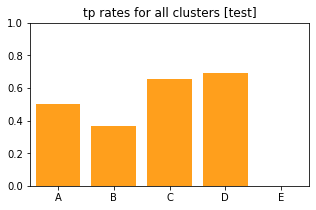

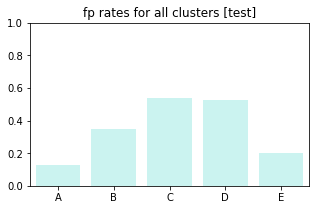

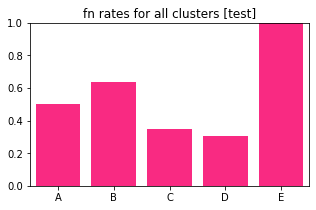

In [9]:
y_trues = []
y_probas = []
y_preds = []
associated_clusters = []
for fold in range(10):
    yts = [baseline['y'][test_idx] for test_idx in baseline[fold]['test_index']]
    ypbs = [yp for yp in baseline[fold]['y_proba']]
    ypds = [ypp for ypp in baseline[fold]['y_pred']]
    acs = [
        baseline['demographics']['cluster_aied_paola'][test_idx] for test_idx in baseline[fold]['test_index']
    ]
    y_trues = [*y_trues, *yts]
    y_probas = [*y_probas, *ypbs]
    y_preds = [*y_preds, *ypds]
    associated_clusters = [*associated_clusters, *acs]
plot_rates(y_trues, y_preds, associated_clusters, 'test')

# Train set

2022-08-31 18:13:14.658582: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 14, 82)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 14, 16)           5824      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 16)               1600      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 7,441
Trainable params: 7,441
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
___________________________

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 14, 82)            0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 14, 16)           5824      
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 16)               1600      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 7,441
Trainable params: 7,441
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_4"
_________________________

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 14, 82)            0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 14, 16)           5824      
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 16)               1600      
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 7,441
Trainable params: 7,441
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_6"
_________________________

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_7 (Reshape)         (None, 14, 82)            0         
                                                                 
 bidirectional_14 (Bidirecti  (None, 14, 16)           5824      
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 16)               1600      
 onal)                                                           
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 7,441
Trainable params: 7,441
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_8"
_________________________

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_9 (Reshape)         (None, 14, 82)            0         
                                                                 
 bidirectional_18 (Bidirecti  (None, 14, 16)           5824      
 onal)                                                           
                                                                 
 bidirectional_19 (Bidirecti  (None, 16)               1600      
 onal)                                                           
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 7,441
Trainable params: 7,441
Non-trainable params: 0
_________________________________________________________________
None


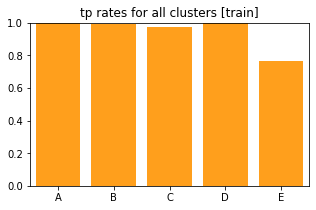

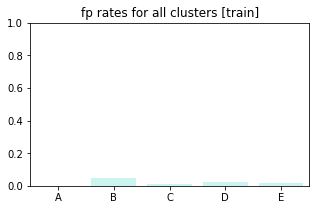

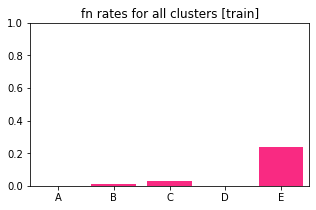

In [11]:
x = [flipped[idx]['sequence'] for idx in range(191)]

root = '../experiments/no_os/flipped/pass/flipped/cluster_demo_features/flipped_bilstm/pass/2022_08_31_0/models/fcbilstm_f'
model_flipped = FlippedBiLSTMModel(config_file)

y_trues = []
y_probas = []
y_preds = []
associated_clusters = []
for fold in range(10):
    xs = [baseline['x'][train_idx] for train_idx in baseline[fold]['train_index']]
    yts = [baseline['y'][train_idx] for train_idx in baseline[fold]['train_index']]
    
    model_flipped.set_outer_fold(fold)
    model_flipped.load_model_weights(x, '{}{}'.format(root, fold))
    
    ypds = model_flipped.predict(xs)
    
    acs = [
        baseline['demographics']['cluster_aied_paola'][train_idx] for train_idx in baseline[fold]['train_index']
    ]
    
    y_trues = [*y_trues, *yts]
    y_preds = [*y_preds, *ypds]
    associated_clusters = [*associated_clusters, *acs]
    
plot_rates(y_trues, y_preds, associated_clusters, 'train')


In [10]:
a = {'1': {'4': '', '5': 3}, '2': {'3':[], '4': []}}

In [11]:
a['1'].update({'hello': [], 'hi': []})

In [12]:
a

{'1': {'4': '', '5': 3, 'hello': [], 'hi': []}, '2': {'3': [], '4': []}}

In [6]:
config_file

{'experiment': {'root_name': 'no_os//x_oversampling/pass',
  'name': '/flipped/cluster_demo_features/flipped_bilstm/pass/2022_08_31_0/',
  'labels': 'pass',
  'n_classes': 2},
 'data': {'dataset': 'flipped',
  'feature': 'cluster_demo_features',
  'label': 'pass',
  'others': {'none': ['x', 'x']},
  'adjuster': {'limit': 'x'}},
 'ml': {'pipeline': {'crossvalidator': 'nonnested',
   'gridsearch': 'none',
   'model': 'flipped_bilstm',
   'gs_splitter': 'none',
   'inner_splitter': 'none',
   'outer_splitter': 'none',
   'splitter': 'stratkf',
   'oversampler': 'none',
   'scorer': 'x'},
  'crossvalidator': {'optim_scoring': 'roc'},
  'nfolds': {'outer': 'x', 'inner': 'x', 'full': 10},
  'splitter': {'shuffle': True, 'stratifier_col': ['pass']},
  'oversampler': {'oversampling_col': ['pass'],
   'rebalancing_mode': 'x',
   'strategy': 'x',
   'noisy': 'x',
   'one_group': 'x',
   'oversampling_factor': 2,
   'shuffler': {'shuffling_coin': 2, 'mode': 'simple', 'chunk_size': 30}},
  'models

In [7]:
import pandas as pd

In [9]:
a

,0,1,2
0,1,2,3
1,3,3,3
2,4,5,6
3,4,6,7


In [10]:
if 'hello' not in a.columns:
    a['hello'] = -1

In [11]:
a

,0,1,2,hello
0,1,2,3,-1
1,3,3,3,-1
2,4,5,6,-1
3,4,6,7,-1


In [13]:
if 'hello' not in a[0]:
    a = a.append({0: 3, 'hello': 'no'}, ignore_index=True)

In [14]:
a

,0,1,2,hello
0,1,2.0,3.0,-1
1,3,3.0,3.0,-1
2,4,5.0,6.0,-1
3,4,6.0,7.0,-1
4,3,NaN,NaN,no


In [6]:
aa = [1, 2, 3, 3, 3, 3]

In [9]:
' '.join([str(aaa) for aaa in aa])

'1 2 3 3 3 3'

In [13]:

a

{'1': {'4': '', '5': 3, 'hello': [], 'hi': []}, '2': {'3': [], '4': []}}

In [14]:
import pickle
with open('./hello.csv', 'rb') as fp:
    hello = pickle.load(fp)

FileNotFoundError: [Errno 2] No such file or directory: './hello.csv'

In [15]:
a = pd.DataFrame([[1, 2, 3], [3, 3, 3], [4, 5, 6], [4, 6, 7]], columns=['hello', 'hi', 'bye'])

In [16]:
a

,hello,hi,bye
0,1,2,3
1,3,3,3
2,4,5,6
3,4,6,7


In [18]:
a.to_csv('test.csv', sep='\t')

In [21]:
b = pd.read_csv('test.csv', sep='\t', index_col=0)

In [22]:
b

,hello,hi,bye
0,1,2,3
1,3,3,3
2,4,5,6
3,4,6,7


In [44]:
c = pd.DataFrame()

In [45]:
c

""


In [46]:
c['key'] = -1

In [47]:
len(c)

0

In [48]:
c[c['key'] == 'hello']

,key


In [31]:
a = {'hello': 1, 'hi': 4}

In [33]:
c.append(a, ignore_index = True)

,key,hello,hi
0,NaN,1.0,4.0


In [35]:
b

,hello,hi,bye
0,1,2,3
1,3,3,3
2,4,5,6
3,4,6,7


In [49]:
b.loc[(b['hello']==4) & (b['hi']==6), 'nooo'] = 'done'

In [50]:
b

,hello,hi,bye,nooo
0,1,2,3,NaN
1,3,3,3,NaN
2,4,5,6,NaN
3,4,6,done,done


In [55]:
b = b.append({'hello': 4, 'nooo': 5}, ignore_index=True)

In [56]:
b

,hello,hi,bye,nooo
0,1.0,2.0,3,NaN
1,3.0,3.0,3,NaN
2,4.0,5.0,6,NaN
3,4.0,6.0,done,done
4,4.0,NaN,NaN,5.0


In [57]:
d = b.to_dict()

In [58]:
d

{'hello': {0: 1.0, 1: 3.0, 2: 4.0, 3: 4.0, 4: 4.0},
 'hi': {0: 2.0, 1: 3.0, 2: 5.0, 3: 6.0, 4: nan},
 'bye': {0: 3, 1: 3, 2: 6, 3: 'done', 4: nan},
 'nooo': {0: nan, 1: nan, 2: nan, 3: 'done', 4: 5.0}}